# FIA-MS data processing and visualization

## Import dependencies and read in the data

- Requires py v3.9 due to PyOpenMS dependencies
- Requires custom installation of BFAIR (see https://github.com/AutoFlowResearch/BFAIR for instructions on installation)

In [1]:
# General py packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# BFAIR py package
import BFAIR.FIA_MS as fia_ms
import BFAIR.normalization as normalization

Define functions and other shared sub-routines not yet integrated into the BFAIR modules

In [6]:
def removeConstFeatures(metabolites, intensities):
    """
    Remove singular or constant features
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    for i, metabolite in enumerate(metabolites):
        row = intensities[intensities["Metabolite"] == metabolite]
        # filter out single- or constant-value features
        if len(row) == 1 or np.std(row["Intensity"]) == 0:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def removeNAFeatures(metabolites, intensities):
    """
    Remove features with more than 50% NAs
    
    Parameters
    ----------
    metabolites : list
        list of unique metabolites
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    
    Returns
    -------
    intensities : pandas.DataFrame
        the filtered metabolites
    """
    intensities_filtered_pivot = intensities.pivot(index="sample_group_name", columns="Metabolite", values="Intensity")
    for i, metabolite in enumerate(metabolites):
        if intensities_filtered_pivot[metabolite].isna().sum() / intensities_filtered_pivot.shape[0] > 0.5:
            index = intensities.index[intensities["Metabolite"] == metabolite].tolist()
            intensities = intensities.drop(labels= index, axis = 0)
    return intensities

def nonParametricRSD(intensities, threshold=0.3):
    """
    Determine the ratio of features in QC samples that
    have a non-parametric %RSD <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities; modified in place
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc_df: pandas.DataFrame
        dataframe with columns for metabolites and the
        Mean, Var, RSD, and np_RSD of each metabolite
    ratio_np_RSD: float
        the ratio of features below the threshold
    ratio_RSD: float
        the ratio of features below the threshold
    """
    stats_qc_dict = {}

    for met in intensities["Metabolite"].unique():
        intensities_met = intensities[intensities["Metabolite"] == met]
        
        mean = np.mean(intensities_met["Intensity"])
        var = np.var(intensities_met["Intensity"])
        rsd = np.sqrt(var) / mean
        
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        np_rsd = (1.4826 * mad) / median
        
        stats_qc_dict[met] = {"Mean" : mean,
                            "Var" : var,
                            "RSD" : rsd,
                            "np_RSD" : np_rsd}

    stats_qc_df = pd.DataFrame.from_dict(stats_qc_dict, "index")
    ratio_np_RSD = stats_qc_df[stats_qc_df["np_RSD"] <= threshold].shape[0] / stats_qc_df.shape[0]
    ratio_RSD = stats_qc_df[stats_qc_df["RSD"] <= threshold].shape[0] / stats_qc_df.shape[0]
    return stats_qc_df, ratio_np_RSD, ratio_RSD

def nonParametricDispersionRatio(intensities, intensities_QCs, threshold=0.5):
    """
    Determine the dispersion ratio of QC samples that
    have a non-parametric ratio <= threshold
    
    Parameters
    ----------
    intensities : pandas.DataFrame
        the extracted intensities;
    intensities_QCs : pandas.DataFrame
        the extracted intensities of only the QCs
    threshold: float
        the threshold to use
    
    Returns
    -------
    stats_qc: pandas.DataFrame
        dataframe with columns for metabolites and the
        dispersion ratio of each metabolite
    ratio_np: float
        the ratio of features below the threshold for
        the non parametric version
    ratio_p: float
        the ratio of features below the threshold for
        the parametric version
    """
    ratio_dict = {}

    for met in intensities["Metabolite"].unique():
        
        intensities_QC_met = intensities_QCs[intensities_QCs["Metabolite"] == met]
        median_qc = np.median(intensities_QC_met["Intensity"])
        mad_qc = np.median(np.absolute(intensities_QC_met["Intensity"] - median_qc))
        sd_qc = np.std(intensities_QC_met["Intensity"])
        
        intensities_met = intensities[intensities["Metabolite"] == met]
        median = np.median(intensities_met["Intensity"])
        mad = np.median(np.absolute(intensities_met["Intensity"] - median))
        sd = np.std(intensities_met["Intensity"])
        
        ratio_np = mad_qc / mad
        ratio_p = sd_qc / sd

        ratio_dict[met] = {"dispersion_ratio_np" : ratio_np,
            "dispersion_ratio_p" : ratio_p}

    dispersion_ratio_df = pd.DataFrame.from_dict(ratio_dict, "index")
    dispersion_ratio_np = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_np"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    dispersion_ratio_p = dispersion_ratio_df[dispersion_ratio_df["dispersion_ratio_p"] <= threshold].shape[0] / dispersion_ratio_df.shape[0]
    return dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p

Set the directories

In [2]:
feature_dir = "Z:/Douglas/AutoFlow data/AFS Experiments/AFS-43-103_FIA-MS_MetEng-NP/features_Bruker"
sequence_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/MetEng-NP-01_ScimaX"
database_dir = "Z:/Douglas/AutoFlow data/SmartPeakBackup/20211212_FIA-MS_MetEngNPDemo/CHEMISTRY"
database_file = "/yeastGEM-Tab-Str_struct.tsv"
sequence_file = "/sequence_SCerevisiae.csv"

Read in the sequence and remove blank rows

<AxesSubplot:xlabel='sample_name'>

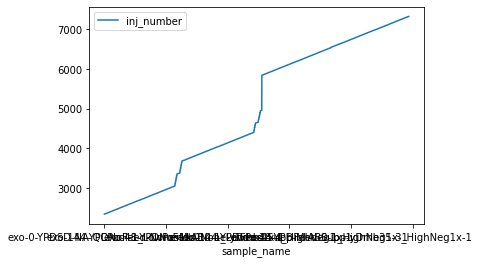

In [3]:
sequence = pd.read_csv(sequence_dir + sequence_file, sep=",")
sequence = sequence[sequence["sample_name"].str.contains("BLANK") == False]

# Quick QC of the data
sequence.plot(x="sample_name", y="inj_number", kind="line")

Read in the database file

In [4]:
database = pd.read_csv(database_dir + database_file, sep="\t", header=None)
database = database.drop(database[database.iloc[:,0].str.contains("EXTRA")].index)

Extract all the relevant information from the provided .featureXML files

<AxesSubplot:xlabel='sample_group_name'>

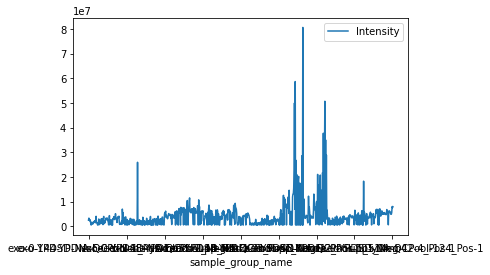

In [5]:
sample_names = sequence["sample_group_name"].unique()
replicate_names = sequence["replicate_group_name"].unique()
intensities = fia_ms.extractNamesAndIntensities(feature_dir, sample_names, database)

# Remove "HMDB:" from metabolite IDs
#intensities["Metabolite"] = intensities["Metabolite"].str.replace("HMDB:", "")

# Quick QC of the data
intensities_selected = intensities[intensities["Metabolite"] == "8__hydroxygeraniol"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")

## Data filtering, normalization, quality control (QC), and basic statistical analysis

Data filtering #1: remove single and constant value features

In [7]:
metabolites = intensities["Metabolite"].unique()

intensities_filtered = removeConstFeatures(metabolites, intensities)
print("Intensities ", intensities.shape[0])
print("Intensities filtered ", intensities_filtered.shape[0])
print("Intensities difference ", intensities.shape[0] - intensities_filtered.shape[0])

Intensities  786185
Intensities filtered  786185
Intensities difference  0


Date filtering #2: remove features with more than 50% NAs

In [8]:
metabolites = intensities_filtered["Metabolite"].unique()

intensities_filtered = removeNAFeatures(metabolites, intensities_filtered)
print("Percent filtered ", 100 * (1 - (intensities_filtered.shape[0]/intensities.shape[0])))

Percent filtered  7.707091842250868


Data QC #1: non-parametric %RSD

In [9]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  0.042028985507246375
Percent QC features with RSD <= 0.3  0.008695652173913044


Data QC #2: non-parametric dispersion ratio

In [10]:
intensities_QC = intensities_filtered[intensities_filtered["sample_group_name"].str.contains("QC")]

dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_filtered, intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)

Percent non parametric dispersion ratio <= 0.5  0.02318840579710145
Percent parametric dispersion ratio <= 0.5  0.06811594202898551


Data normalize #1: Total sum intensity (tsi) sample normalization and log transformation

array([[<AxesSubplot:title={'center':'Intensity'}>]], dtype=object)

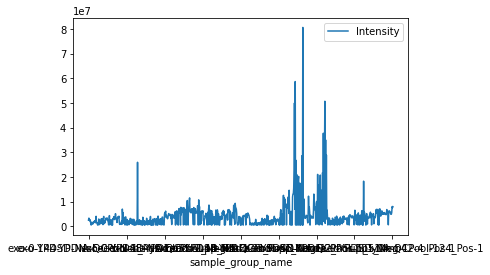

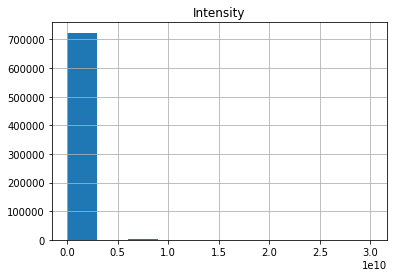

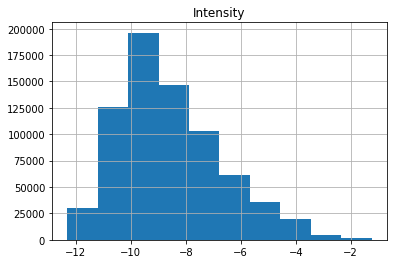

In [11]:
intensities_tsi = normalization.tsi_norm(intensities_filtered)
intensities_tsi["Intensity"] = np.log(intensities_tsi["Intensity"])

intensities_selected = intensities[intensities["Metabolite"] == "8__hydroxygeraniol"]
intensities_selected.plot(x="sample_group_name", y="Intensity", kind="line")
intensities_filtered.hist("Intensity")
intensities_tsi.hist("Intensity")

Data QC #3: parametric %RSD

In [12]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
stats_qc_df, ratio_np_RSD, ratio_RSD = nonParametricRSD(normalized_intensities_QC)
print("Percent QC features with NP RSD <= 0.3 ", ratio_np_RSD)
print("Percent QC features with RSD <= 0.3 ", ratio_RSD)

Percent QC features with NP RSD <= 0.3  1.0
Percent QC features with RSD <= 0.3  1.0


Data QC #4: parametric dispersion ratio

In [13]:
normalized_intensities_QC = intensities_tsi[intensities_tsi["sample_group_name"].str.contains("QC")]
dispersion_ratio_df, dispersion_ratio_np, dispersion_ratio_p = nonParametricDispersionRatio(intensities_tsi, normalized_intensities_QC)
print("Percent non parametric dispersion ratio <= 0.5 ", dispersion_ratio_np)
print("Percent parametric dispersion ratio <= 0.5 ", dispersion_ratio_p)


Percent non parametric dispersion ratio <= 0.5  0.0536231884057971
Percent parametric dispersion ratio <= 0.5  0.010144927536231883


Data filtering #3: remove high variable features (QC > 30% RSD)

In [14]:
to_discard = stats_qc_df[np.abs(stats_qc_df["RSD"]) > 0.3]
to_discard.index.name = 'Metabolite'
to_discard.reset_index(inplace=True)
intensities_tsi_filt = intensities_tsi[~intensities_tsi["Metabolite"].isin(to_discard["Metabolite"])]

print("Intensities ", intensities_tsi.shape[0])
print("Intensities filtered ", intensities_tsi_filt.shape[0])
print("Intensities difference ", intensities_tsi.shape[0] - intensities_tsi_filt.shape[0])

Intensities  725593
Intensities filtered  702441
Intensities difference  23152


Data filtering #4: remove samples without the minimum number of replicates and highly variable features (> 50% RSD)

In [15]:
%%capture
intensities_stats = fia_ms.calculateMeanVarRSD(intensities_tsi_filt, sequence.drop_duplicates(["sample_group_name", "replicate_group_name"]), min_reps=2)

In [ ]:
# Filter metabolites
to_discard = intensities_stats[np.abs(intensities_stats["RSD"]) > 0.5]
to_discard_mets = to_discard["Metabolite"].unique()

# Filter sample_group_names
to_keep_injections = sequence[sequence["replicate_group_name"].isin(intensities_stats["replicate_group_name"])]

intensities_tsi_filt2 = intensities_tsi_filt[~intensities_tsi_filt["Metabolite"].isin(to_discard_mets) & intensities_tsi_filt["sample_group_name"].isin(to_keep_injections["sample_group_name"].unique())]
print("n discarded metabolites", len(to_discard_mets))
print("Intensities ", intensities_tsi_filt.shape[0])
print("Intensities filtered ", intensities_tsi_filt2.shape[0])
print("Intensities difference ", intensities_tsi_filt.shape[0] - intensities_tsi_filt2.shape[0])

n discarded metabolites 1
Intensities  702441
Intensities filtered  701206
Intensities difference  1235


Data QC #5: Visualization of the mean and RSD

In [ ]:
#intensities_selected = intensities_stats[intensities_stats["Metabolite"] == "8__hydroxygeraniol"]

sns.violinplot(x="replicate_group_name", y="Mean", data=intensities_stats, orient = 'v')
plt.xticks(rotation=70)
plt.title('Mean', size = 20)

In [ ]:
sns.violinplot(x="replicate_group_name", y="RSD", data=intensities_stats, orient = 'v')
plt.xticks(rotation=70)
plt.title('RSD', size = 20)

Data QC #5: PCA of replicates, blanks, and QCs

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Split into smaller subsets by batch, polarity, compartment, etc.
batch_names = ["MetEngDemo","NPDemo"]
scan_polarities = ["positive","negative"]
sample_types = ["Blank","QC","Unknown"]
cellular_location = ["exo-", "endo-"]

# Define the sequence subsets using the pattern batch_name/scan_polarity/sample_type/cellular_location
sequence_MetEngDemo_Pos_All_All = sequence[sequence["batch_name"].str.contains("MetEngDemo") & sequence["replicate_group_name"].str.contains("endo-")]

# Create the subset and pivot table
intensities_subset = intensities_tsi_filt2[intensities_tsi_filt2["sample_group_name"].isin(sequence_MetEngDemo_Pos_All_All["sample_group_name"].unique())]
intensities_piv = intensities_subset.pivot("sample_group_name", "Metabolite", "Intensity")
intensities_piv = intensities_piv.fillna(0)

In [ ]:
# min/max scale the data
scaler = MinMaxScaler()
intensities_piv_scaled = scaler.fit_transform(intensities_piv)

# pca
pca = PCA(n_components = 10)
comps = pca.fit_transform(intensities_piv_scaled)

In [ ]:
# Scree plot
print(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
# plot the scores
data_plot = pd.DataFrame(data = comps, columns =  ['pca1', 'pca2',
    'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10'])

# add in the sample_group_names as the labels
labels = intensities_piv.index
data_plot["sample_group_names"] = labels

# add in the replicate_group_name to define the colors
data_plot["replicate_group_name"] = ""
for i,row in data_plot.iterrows():
    index = np.where(sequence["sample_group_name"] == row["sample_group_names"])[0]
    data_plot["replicate_group_name"].iloc[i] = sequence["replicate_group_name"][index[0]]

# define the colors based on the replicate_group_names
data_plot["color"] = ""
for i,row in data_plot.iterrows():
    # add colors
    if row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Pos":
        data_plot["color"].iloc[i] = "#000000"
    elif row["replicate_group_name"] == "exo-0-YPDSD-NA-QCPool_Neg":
        data_plot["color"].iloc[i] = "#929292"
    elif row["replicate_group_name"] == "exo-144-YPDFeed-Supp-yDmb31_Pos":
        data_plot["color"].iloc[i] = "#0037ea"
    elif row["replicate_group_name"] == "exo-144-YPDFeed-Supp-yDmb31_Neg":
        data_plot["color"].iloc[i] = "#00b5ff"
    else:
        data_plot["color"].iloc[i] = "#feb24c"

# Make the PCA plot with loadings plot and scree plot for axes 1 to 3
for j in range(1,4):
    for k in range(j+1,4):

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('Principal Component ' + str(j) + ' ( ' + str(round(pca.explained_variance_[j-1])) + '% )' , fontsize = 20)
        ax.set_ylabel('Principal Component ' + str(k) + ' ( ' + str(round(pca.explained_variance_[k-1])) + '% )' , fontsize = 20)
        ax.set_title('PCA (Axis' + str(j) + ' & ' + str(k) + ')', fontsize = 20)

        plt.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.1)
        plt.xticks(size = 20)
        #plt.xlabel(size = 20)
        plt.yticks(size = 20)
        #plt.ylabel(size = 20)

        for i, label in enumerate(data_plot["sample_group_names"]):
            x, y = data_plot["pca" + str(j)][i], data_plot["pca" + str(k)][i]
            ax.plot(x, y, ".", markersize=15, label=label)
            
            ax.annotate(data_plot["sample_group_names"][i], (x - 0.5 , y), weight='bold',
                        color='white',
                        bbox=dict(boxstyle="round",
                        facecolor=data_plot["color"][i], edgecolor=data_plot["color"][i],
                       )
                       )

Data QC #6: Check technical replicate correlation (R > 0.9)

In [ ]:
# todo

## Statistical and pathway analyses

Hierarchical clustering analysis without pre-processing

In [ ]:
g = sns.clustermap(intensities_tsi_filt2, pivot_kws=["sample_group_name", "Metabolite", "Intensity"], method="complete", metric="euclidean")

Clustering analysis with pre-processing using PCA

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

In [ ]:
# todo
# Pre-process using PCA

In [ ]:
clustering = AgglomerativeClustering(n_clusters=3, linkage="ward") #KMeans
Y_preds = clustering.fit_predict(X)

In [ ]:
def plot_actual_prediction(X, Y, Y_preds):
    with plt.style.context(("ggplot", "seaborn")):
        plt.figure(figsize=(17,6))

        plt.subplot(1,2,1)
        plt.scatter(X[Y==0,0],X[Y==0,1], c = 'red', marker="^", s=50)
        plt.scatter(X[Y==1,0],X[Y==1,1], c = 'green', marker="^", s=50)
        plt.scatter(X[Y==2,0],X[Y==2,1], c = 'blue', marker="^", s=50)
        plt.title("Original Data")

        plt.subplot(1,2,2)
        plt.scatter(X[Y_preds==0,0],X[Y_preds==0,1], c = 'red', marker="^", s=50)
        plt.scatter(X[Y_preds==1,0],X[Y_preds==1,1], c = 'green', marker="^", s=50)
        plt.scatter(X[Y_preds==2,0],X[Y_preds==2,1], c = 'blue', marker="^", s=50)

        plt.title("Clustering Algorithm Prediction")

In [ ]:
adjusted_rand_score(Y, Y_preds)
adjusted_mutual_info_score(Y, Y_preds)
silhouette_score(Y, Y_preds, metric='euclidean')
plot_actual_prediction(X, Y, Y_preds)

In [ ]:
# todo

Pathway enrichment analysis

In [ ]:
# todo

Volcano plot

In [ ]:
# todo